In [1]:
import random,datetime
from bisect import bisect_left
from enum import Enum
from math import exp
import math
from itertools import chain
import matplotlib.pyplot as plt

In [2]:
def _mutate_custom(parent, custom_mutate, get_fitness):
    childGenes = parent.Genes[:]
    custom_mutate(childGenes)
    fitness = get_fitness(childGenes)
    return Chromosome(childGenes, fitness, Strategies.Mutate)

def _crossover(parentGenes, index, parents, get_fitness, crossover, mutate,
               generate_parent):
    donorIndex = random.randrange(0, len(parents))
    if donorIndex == index:
        donorIndex = (donorIndex + 1) % len(parents)
    childGenes = crossover(parentGenes, parents[donorIndex].Genes)
    if childGenes is None:
        parents[donorIndex] = generate_parent()
        return mutate(parents[index])
    fitness = get_fitness(childGenes)
    return Chromosome(childGenes, fitness, Strategies.Crossover)


def get_best(get_fitness, targetLen, optimalFitness, geneSet, display,
             custom_mutate=None, custom_create=None, maxAge=None,
             poolSize=1, crossover=None):
    if custom_mutate is None:
        def fnMutate(parent):
            return _mutate(parent, geneSet, get_fitness)
    else:
        def fnMutate(parent):
            return _mutate_custom(parent, custom_mutate, get_fitness)

    if custom_create is None:
        def fnGenerateParent():
            return _generate_parent(targetLen, geneSet, get_fitness)
    else:
        def fnGenerateParent():
            genes = custom_create()
            return Chromosome(genes, get_fitness(genes), Strategies.Create)

    strategyLookup = {
        Strategies.Create: lambda p, i, o: fnGenerateParent(),
        Strategies.Mutate: lambda p, i, o: fnMutate(p),
        Strategies.Crossover: lambda p, i, o:
        _crossover(p.Genes, i, o, get_fitness, crossover, fnMutate,
                   fnGenerateParent)
    }

    usedStrategies = [strategyLookup[Strategies.Mutate]]
    if crossover is not None:
        usedStrategies.append(strategyLookup[Strategies.Crossover])

        def fnNewChild(parent, index, parents):
            return random.choice(usedStrategies)(parent, index, parents)
    else:
        def fnNewChild(parent, index, parents):
            return fnMutate(parent)

    for improvement in _get_improvement(fnNewChild, fnGenerateParent,
                                        maxAge, poolSize):
        display(improvement)
        f = strategyLookup[improvement.Strategy]
        usedStrategies.append(f)
        if not optimalFitness > improvement.Fitness:
            return improvement


def _get_improvement(new_child, generate_parent, maxAge, poolSize):
    bestParent = generate_parent()
    yield bestParent
    parents = [bestParent]
    historicalFitnesses = [bestParent.Fitness]
    for _ in range(poolSize - 1):
        parent = generate_parent()
        if parent.Fitness > bestParent.Fitness:
            yield parent
            bestParent = parent
            historicalFitnesses.append(parent.Fitness)
        parents.append(parent)
    lastParentIndex = poolSize - 1
    pindex = 1
    while True:
        pindex = pindex - 1 if pindex > 0 else lastParentIndex
        parent = parents[pindex]
        child = new_child(parent, pindex, parents)
        if parent.Fitness > child.Fitness:
            if maxAge is None:
                continue
            parent.Age += 1
            if maxAge > parent.Age:
                continue
            index = bisect_left(historicalFitnesses, child.Fitness, 0,
                                len(historicalFitnesses))
            proportionSimilar = index / len(historicalFitnesses)
            if random.random() < exp(-proportionSimilar):
                parents[pindex] = child
                continue
            bestParent.Age = 0
            parents[pindex] = bestParent
            continue
        if not child.Fitness > parent.Fitness:
            child.Age = parent.Age + 1
            parents[pindex] = child
            continue
        child.Age = 0
        parents[pindex] = child
        if child.Fitness > bestParent.Fitness:
            bestParent = child
            yield bestParent
            historicalFitnesses.append(bestParent.Fitness)

class Chromosome:
    def __init__(self, genes, fitness, strategy):
        self.Genes = genes
        self.Fitness = fitness
        self.Strategy = strategy
        self.Age = 0

class Strategies(Enum):
    Create = 0,
    Mutate = 1,
    Crossover = 2

In [3]:
def get_fitness(genes, idToLocationLookup):
    fitness = get_distance(idToLocationLookup[genes[0]],
                           idToLocationLookup[genes[-1]])

    for i in range(len(genes) - 1):
        start = idToLocationLookup[genes[i]]
        end = idToLocationLookup[genes[i + 1]]
        fitness += get_distance(start, end)

    return Fitness(round(fitness, 2))


def display(candidate, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}\t{}".format(
        ' '.join(map(str, candidate.Genes)),
        candidate.Fitness,
        candidate.Strategy.name,
        timeDiff))

def display2(loc,gens):
    x ,y ,n= [],[],[]
    for i in loc:
        x.append(loc[i][0])
        y.append(loc[i][1])
        n.append(i)
    plt.scatter(x,y)
    for i in range(len(x)):
        plt.text(x[i]-0.3,y[i]-0.1,n[i])
    for i in range(len(gens)-1):
        k = gens[i]
        k2 = gens[i+1]
        d = round(get_distance(loc[k],loc[k2]),2)
        plt.annotate(d,xy=(loc[k2][0], loc[k2][1]),xytext=(loc[k][0], loc[k][1]),
                    arrowprops=dict(arrowstyle="->", color="r"))
    plt.title("->".join(gens))

def get_distance(locationA, locationB):
    sideA = locationA[0] - locationB[0]
    sideB = locationA[1] - locationB[1]
    sideC = math.sqrt(sideA * sideA + sideB * sideB)
    return sideC


def mutate(genes, fnGetFitness):
    count = random.randint(2, len(genes))
    initialFitness = fnGetFitness(genes)
    while count > 0:
        count -= 1
        indexA, indexB = random.sample(range(len(genes)), 2)
        genes[indexA], genes[indexB] = genes[indexB], genes[indexA]
        fitness = fnGetFitness(genes)
        if fitness > initialFitness:
            return


def crossover(parentGenes, donorGenes, fnGetFitness):

    pairs = {Pair(donorGenes[0], donorGenes[-1]): 0}

    for i in range(len(donorGenes) - 1):
        pairs[Pair(donorGenes[i], donorGenes[i + 1])] = 0

    tempGenes = parentGenes[:]
    if Pair(parentGenes[0], parentGenes[-1]) in pairs:
        found = False
        for i in range(len(parentGenes) - 1):
            if Pair(parentGenes[i], parentGenes[i + 1]) in pairs:
                continue
            tempGenes = parentGenes[i + 1:] + parentGenes[:i + 1]
            found = True
            break
        if not found:
            return None

    runs = [[tempGenes[0]]]
    for i in range(len(tempGenes) - 1):
        if Pair(tempGenes[i], tempGenes[i + 1]) in pairs:
            runs[-1].append(tempGenes[i + 1])
            continue
        runs.append([tempGenes[i + 1]])

    initialFitness = fnGetFitness(parentGenes)
    count = random.randint(2, 20)
    runIndexes = range(len(runs))
    while count > 0:
        count -= 1
        for i in runIndexes:
            if len(runs[i]) == 1:
                continue
            if random.randint(0, len(runs)) == 0:
                runs[i] = [n for n in reversed(runs[i])]

        indexA, indexB = random.sample(runIndexes, 2)
        runs[indexA], runs[indexB] = runs[indexB], runs[indexA]
        childGenes = list(chain.from_iterable(runs))
        if fnGetFitness(childGenes) > initialFitness:
            return childGenes
    return childGenes

In [4]:
class Fitness:
    def __init__(self, totalDistance):
        self.TotalDistance = totalDistance

    def __gt__(self, other):
        return self.TotalDistance < other.TotalDistance

    def __str__(self):
        return "{:0.2f}".format(self.TotalDistance)


class Pair:
    def __init__(self, node, adjacent):
        if node < adjacent:
            node, adjacent = adjacent, node
        self.Node = node
        self.Adjacent = adjacent

    def __eq__(self, other):
        return self.Node == other.Node and self.Adjacent == other.Adjacent

    def __hash__(self):
        return hash(self.Node) * 397 ^ hash(self.Adjacent)

In [5]:
idToLocationLookup = {
            'A': [4, 7],
            'B': [2, 6],
            'C': [0, 5],
            'D': [1, 3],
            'E': [3, 0],
            'F': [5, 1],
            'G': [7, 2],
            'H': [6, 4]}
optimalSequence = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

In [6]:
def solve(idToLocationLookup, optimalSequence):
        geneset = [i for i in idToLocationLookup.keys()]

        def fnCreate():
            return random.sample(geneset, len(geneset))

        def fnDisplay(candidate):
            display(candidate, startTime)

        def fnGetFitness(genes):
            return get_fitness(genes, idToLocationLookup)

        def fnMutate(genes):
            mutate(genes, fnGetFitness)

        def fnCrossover(parent, donor):
            return crossover(parent, donor, fnGetFitness)

        optimalFitness = fnGetFitness(optimalSequence)
        startTime = datetime.datetime.now()
        best = get_best(fnGetFitness, None, optimalFitness, None,
                                fnDisplay, fnMutate, fnCreate, maxAge=500,
                                poolSize=25, crossover=fnCrossover)
        return best

In [7]:
x = solve(idToLocationLookup, optimalSequence)

G C H E F D B A	36.64	Create	0:00:00
A B D C H G F E	27.50	Create	0:00:00.001000
G F H A B C D E	23.79	Create	0:00:00.001000
C E F G H A B D	23.78	Create	0:00:00.001995
H G E F D C B A	23.73	Create	0:00:00.003988
C D E F G H A B	20.63	Crossover	0:00:00.014960


In [8]:
x.Genes

['C', 'D', 'E', 'F', 'G', 'H', 'A', 'B']

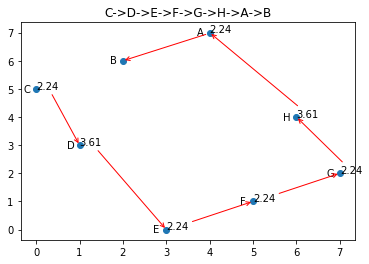

In [9]:
display2(idToLocationLookup,x.Genes)